In [2]:
pip install shapely

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.4 MB 8.5 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 8.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install svgwrite

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
from shapely.ops import unary_union
from shapely.validation import make_valid
from rdp import rdp
import svgwrite


In [15]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs

In [4]:
def fit_bezier_curve(points, num_points=100):
    if len(points) < 2:
        return points
    tck, u = splprep([points[:, 0], points[:, 1]], s=0)
    u_fine = np.linspace(0, 1, num_points)
    x_fine, y_fine = splev(u_fine, tck)
    return np.vstack((x_fine, y_fine)).T


In [20]:
def plot_curves(paths_XYs, colours):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            if len(XY) > 2:
                bezier_curve = fit_bezier_curve(XY)
                ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], c=c, linewidth=2)
                ax.fill(bezier_curve[:, 0], bezier_curve[:, 1], c=c, alpha=0.3)
            else:
                ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
                ax.fill(XY[:, 0], XY[:, 1], c=c, alpha=0.3)
    ax.set_aspect('equal')
    plt.show()

In [21]:
def fill_occlusions(paths_XYs):
    filled_paths = []
    for path in paths_XYs:
        filled_path = []
        for shape in path:
            if len(shape) > 2:  # Only process shapes with more than 2 points
                hull = ConvexHull(shape)
                filled_shape = shape[hull.vertices]
            else:
                filled_shape = shape
            filled_path.append(filled_shape)
        filled_paths.append(filled_path)
    return filled_paths

In [22]:
def rdp_simplify(path_XYs, epsilon=1.0):
    simplified_paths = []
    for path in path_XYs:
        simplified_path = []
        for shape in path:
            if len(shape) > 2:
                simplified_shape = rdp(shape, epsilon=epsilon)
                simplified_path.append(simplified_shape)
            else:
                simplified_path.append(shape)
        simplified_paths.append(simplified_path)
    return simplified_paths

In [29]:
def analyze_connectivity(paths_XYs):
    polygons = []
    for path in paths_XYs:
        for shape in path:
            if len(shape) > 2:
                polygon = Polygon(shape)
                if polygon.is_valid:
                    polygons.append(polygon)
                else:
                    repaired_polygon = make_valid(polygon)
                    polygons.append(repaired_polygon)

    if not polygons:
        return "Disconnected"

    try:
        multi_polygon = MultiPolygon(polygons)
        unified_polygon = unary_union(multi_polygon)

        if isinstance(unified_polygon, Polygon):
            return "Connected"
        elif isinstance(unified_polygon, MultiPolygon):
            if len(unified_polygon.geoms) == 1:
                return "Connected"
            else:
                return "Disconnected"
        elif isinstance(unified_polygon, GeometryCollection):
            valid_polygons = [geom for geom in unified_polygon.geoms if isinstance(geom, Polygon) and geom.is_valid]
            if valid_polygons:
                multi_polygon = MultiPolygon(valid_polygons)
                if len(multi_polygon.geoms) == 1:
                    return "Connected"
                else:
                    return "Disconnected"
            else:
                return "Disconnected"
    except Exception as e:
        return "Disconnected"


In [34]:
def process_csv_and_fill_occlusions(input_csv, colours):
    input_paths_XYs = read_csv(input_csv)

    simplified_paths_XYs = rdp_simplify(input_paths_XYs, epsilon=1.0)
    plot_curves(simplified_paths_XYs, colours)
    input_result = analyze_connectivity(simplified_paths_XYs)

    filled_paths_XYs = fill_occlusions(simplified_paths_XYs)
    print("Plotting filled curves...")
    plot_curves(filled_paths_XYs, colours)
    output_result = analyze_connectivity(filled_paths_XYs)

    

In [35]:
def polylines2svg(paths_XYs, filename, colours):
    dwg = svgwrite.Drawing(filename, profile='tiny')
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            points = [(x, y) for x, y in XY]
            dwg.add(dwg.polyline(points, stroke=c, fill='none', stroke_width=2))
    dwg.save()

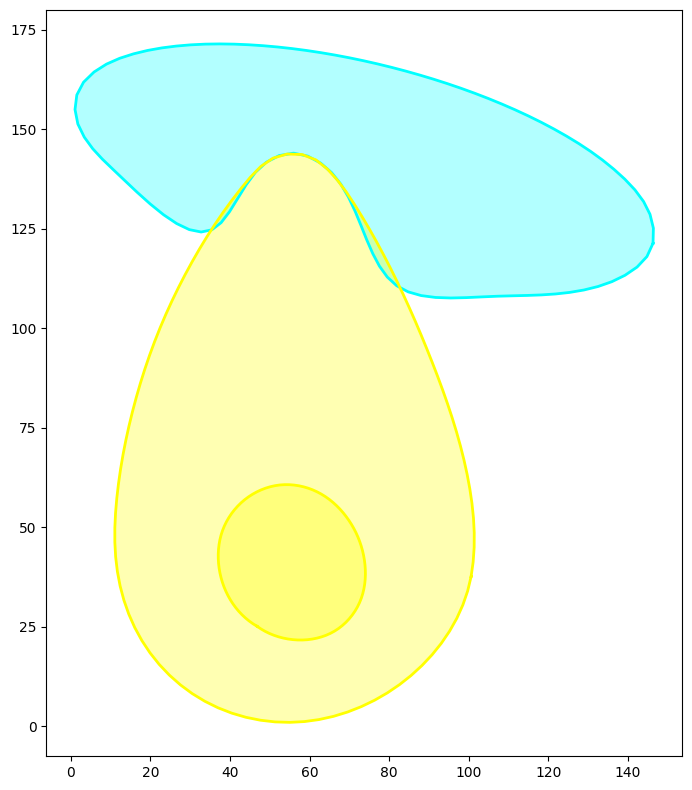

Plotting filled curves...


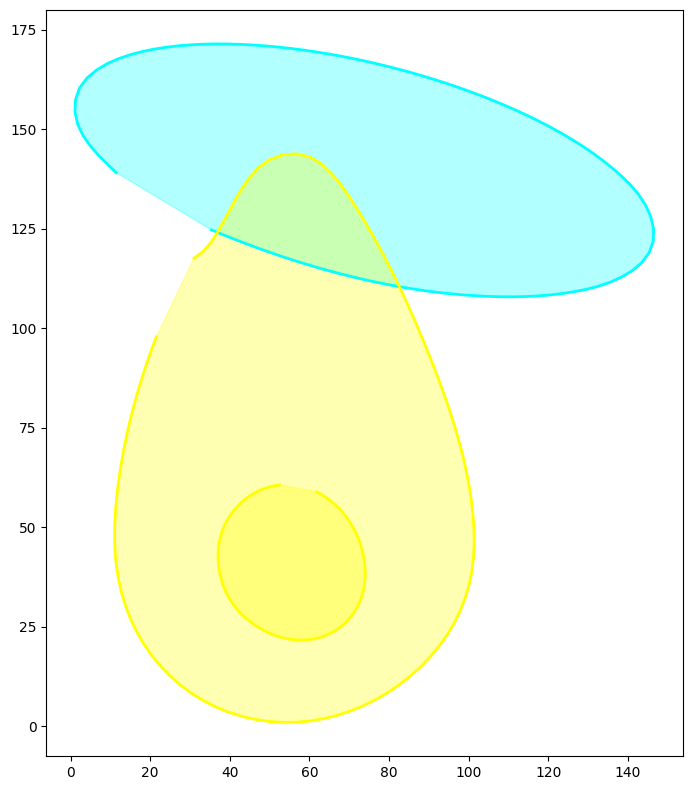

In [36]:
input_csv = 'problems/occlusion1.csv'
colours = ['cyan', 'yellow']

process_csv_and_fill_occlusions(input_csv, colours)

paths_XYs=read_csv(input_csv)
simplified_paths_XYs = rdp_simplify(paths_XYs, epsilon=1.0)
polylines2svg(simplified_paths_XYs, 'simplified_paths.svg', colours)

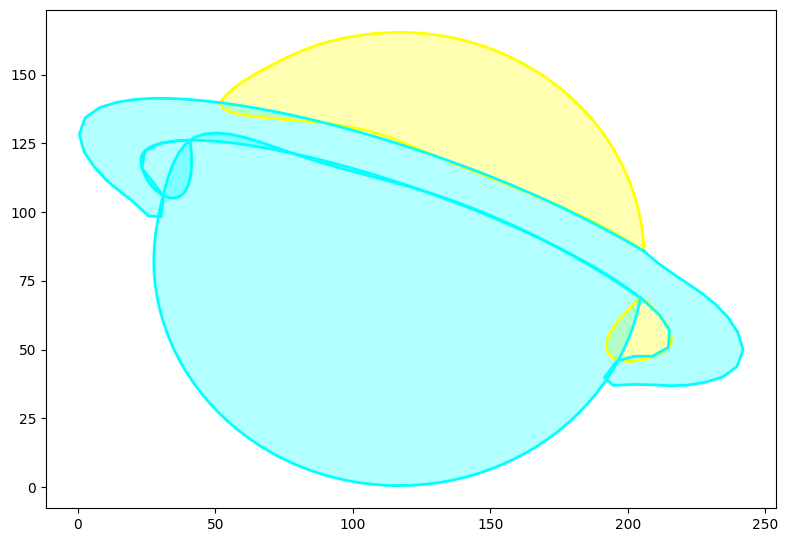

Plotting filled curves...


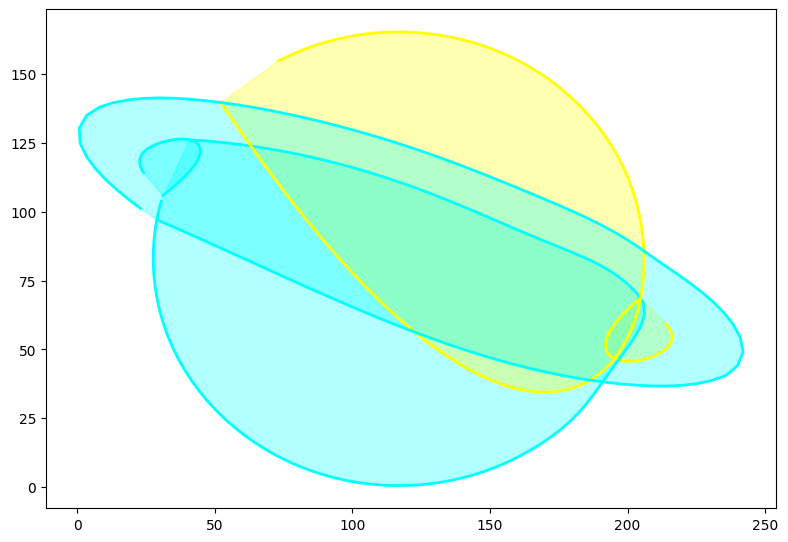

In [37]:
input_csv = 'problems/occlusion2.csv'
colours = ['cyan', 'yellow']

process_csv_and_fill_occlusions(input_csv, colours)

paths_XYs=read_csv(input_csv)
simplified_paths_XYs = rdp_simplify(paths_XYs, epsilon=1.0)
polylines2svg(simplified_paths_XYs, 'simplified_paths.svg', colours)
     